# OUTLIER DETECTION

__Identify the top 1% outliers__: adopt at least three different methods from different families (e.g., density-based, angle-based… ) and compare the results. 

Deal with the outliers by __removing them__ from the dataset or by treating the anomalous variables as missing values and employing __replacement techniques__. In this second case, you should check that the outliers are not outliers anymore. Justify your choices in every step.

In this notebook will be tested three different types of Outlier detection method:

**1) ABOD** that is a **high dimensional approach**

**2) Standard and Extended Isolation forest** that are **model based approaches**

**3) LOF** that is a **density based approach**

In [242]:
import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="whitegrid")
sns.set_color_codes()

from collections import defaultdict

In [243]:
df_train = pd.read_csv('csv/train.csv')
df_test = pd.read_csv('csv/test.csv')

In [244]:
# Define the Target attribute "Class" - Walk upstairs

df_train['Class'] = 0
df_test['Class'] = 0

df_train.loc[(df_train['Activity']==2), 'Class'] = 1
df_test.loc[(df_test['Activity']==2), 'Class'] = 1

In [245]:
to_drop = ['ActivityName','Class','subject']    
X_train = df_train.drop(to_drop, axis=1, inplace=False)
X_test = df_test.drop(to_drop, axis=1, inplace=False)

In [246]:
# Division between activities of motion (1,2,3) and static activities (4,5,6)

X_train_motion = X_train[X_train["Activity"]<=3]
X_train_static = X_train[X_train["Activity"]>3]

X_test_motion = X_test[X_test["Activity"]<=3]
X_test_static = X_test[X_test["Activity"]>3]

In [247]:
print(pd.unique(X_train_motion['Activity']))

[1 3 2]


In [248]:
print(pd.unique(X_test_motion['Activity']))

[1 3 2]


In [249]:
print(pd.unique(X_train_static['Activity']))

[5 4 6]


In [250]:
print(pd.unique(X_test_static['Activity']))

[5 4 6]


## 1. HIGH DIMENSIONAL APPROACHES

### 1.1 ABOD  Angle-Based Outlier Degree  PYOD

### Motion activities

In [314]:
from pyod.models.abod import ABOD

https://pyod.readthedocs.io/en/latest/pyod.models.html?highlight=abod#pyod.models.abod.ABOD

In [332]:
Abod = ABOD(contamination=0.005)

In [333]:
Abod.fit(X_train_motion)

# contamination of the data set, i.e. the proportion of outliers in the data set. 
# Used when fitting to define the threshold on the decision function.

ABOD(contamination=0.005, method='fast', n_neighbors=5)

In [334]:
Abod.decision_scores_
# The higher, the more abnormal. Outliers tend to have higher scores. 
# This value is available once the detector is fitted.

array([-5.98092657e-05, -7.55986760e-05, -2.58994726e-05, ...,
       -1.75294243e-04, -1.03815217e-04, -5.41070915e-05])

In [335]:
Abod.threshold_
# The threshold is based on contamination. 
# It is the n_samples * contamination most abnormal samples in decision_scores_. 
# The threshold is calculated for generating binary outlier labels.
# top n outliers = 7352 * 0.1 = 735.2

-5.6174410861146476e-06

In [336]:
# OUTLIER PREDICTION SUL TEST SET 

ABOD_predict = Abod.predict(X_test_motion)
np.unique(ABOD_predict, return_counts=True)
# 0 stands for inliers and 1 for outliers.

(array([0, 1]), array([1347,   40]))

In [337]:
# OUTLIER LABELS TRAINING SET
np.unique(Abod.labels_, return_counts=True)

(array([0, 1]), array([3268,   17]))

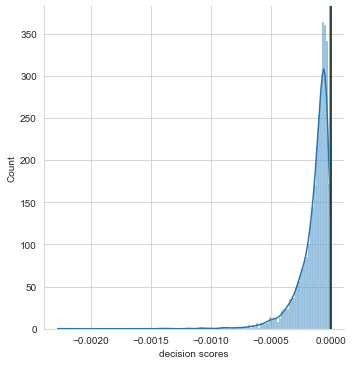

In [338]:
ABOD_outliers = Abod.decision_scores_[np.where(ABOD_predict==1)]
ABOD_inliers = Abod.decision_scores_[np.where(ABOD_predict==0)]

sns.displot(Abod.decision_scores_, kind="hist" , kde = True)
plt.axvline(np.min(Abod.decision_scores_[np.where(Abod.labels_==1)]), c='g')
plt.axvline(np.max(Abod.decision_scores_[np.where(Abod.labels_==1)]), c='k')
plt.xlabel("decision scores")
#plt.title("ABOD decision score")
plt.show()

In [339]:
abod_outliers_train_motion = np.where(Abod.labels_==1)
abod_outliers_train_motion

(array([ 625,  628,  637,  847,  915, 1161, 1224, 1777, 1797, 1812, 1816,
        1818, 1820, 1821, 2144, 2184, 2244]),)

### Static activities

In [340]:
Abod = ABOD(contamination=0.005)

In [341]:
Abod.fit(X_train_static)

ABOD(contamination=0.005, method='fast', n_neighbors=5)

In [342]:
# OUTLIER LABELS TRAINING SET
np.unique(Abod.labels_, return_counts=True)

(array([0, 1]), array([4046,   21]))

In [343]:
# OUTLIER PREDICTION SUL TEST SET 

ABOD_predict = Abod.predict(X_test_static)
np.unique(ABOD_predict, return_counts=True)

(array([0, 1]), array([1528,   32]))

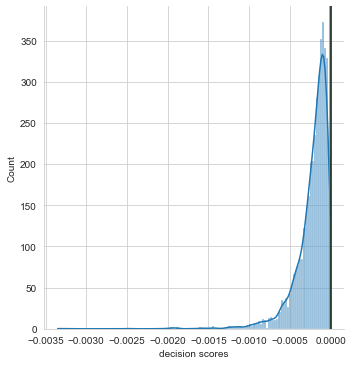

In [344]:
ABOD_outliers = Abod.decision_scores_[np.where(ABOD_predict==1)]
ABOD_inliers = Abod.decision_scores_[np.where(ABOD_predict==0)]

sns.displot(Abod.decision_scores_, kind="hist" , kde = True)
plt.axvline(np.min(Abod.decision_scores_[np.where(Abod.labels_==1)]), c='g')
plt.axvline(np.max(Abod.decision_scores_[np.where(Abod.labels_==1)]), c='k')
plt.xlabel("decision scores")
# plt.title("ABOD decision score")
plt.show()

In [345]:
abod_outliers_train_static = np.where(Abod.labels_==1)
abod_outliers_train_static

(array([  67,   71,  140,  279,  292,  309,  432,  617,  924,  937,  953,
        1014, 1260, 1525, 1602, 1735, 1853, 2025, 2243, 2858, 2862]),)

In [346]:
np.intersect1d(abod_outliers_test_static, abod_outliers_test_motion)

array([1164])

## 2. MODEL-BASED APPROACHES

Codici seguenti ripresi da:
https://towardsdatascience.com/how-to-detect-outliers-with-python-pyod-aa7147359e4b

### 2.1 Standard Isolation Forest  (sklearn)

### Motion activities

In [347]:
from sklearn.ensemble import IsolationForest

In [348]:
if_sk = IsolationForest(n_estimators = 100, 
                        max_samples = 256,
                        contamination = 0.005,  
                        random_state = np.random.RandomState(42))

In [349]:
outliers_motion_train = if_sk.fit_predict(X_train_motion)
outliers_motion_test = if_sk.predict(X_test_motion)

/Users/riccardo/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [350]:
# 1 for inliers, -1 for outliers.
np.unique(outliers_motion_train, return_counts=True)

(array([-1,  1]), array([  17, 3268]))

In [351]:
# Negative scores represent outliers, positive scores represent inliers.
X_train_score_motion = if_sk.decision_function(X_train_motion)
X_test_score_motion = if_sk.decision_function(X_test_motion)

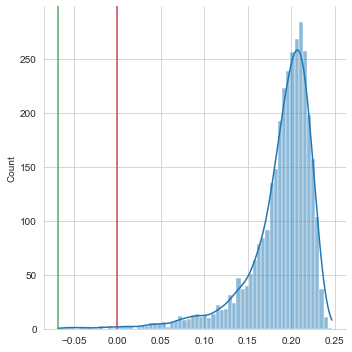

In [352]:
sns.displot(X_train_score_motion, kind="hist" , kde = True)
plt.axvline(np.min(X_train_score_motion[np.where(outliers_motion_train==-1)]), c='g')
plt.axvline(np.max(X_train_score_motion[np.where(outliers_motion_train==-1)]), c='r')
# plt.title('Standard Isolation Forest (sklearn)', fontsize=15)
plt.show()

In [353]:
iso_outliers_train_motion = np.where(outliers_motion_train==-1)
iso_outliers_train_motion

(array([ 628, 1229, 1236, 1810, 1811, 1812, 1814, 1816, 1817, 1818, 1819,
        1820, 1821, 1836, 1837, 1839, 1840]),)

In [354]:
np.intersect1d(abod_outliers_train_motion, iso_outliers_train_motion)

array([ 628, 1812, 1816, 1818, 1820, 1821])

### Static activities

In [355]:
if_sk = IsolationForest(n_estimators = 100, 
                        max_samples = 256,
                        contamination = 0.005,  
                        random_state = np.random.RandomState(42))

In [356]:
outliers_static_train = if_sk.fit_predict(X_train_static)
outliers_static_test = if_sk.predict(X_test_static)

/Users/riccardo/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [357]:
# 1 for inliers, -1 for outliers.
np.unique(outliers_static_train, return_counts=True)

(array([-1,  1]), array([  21, 4046]))

In [358]:
# Negative scores represent outliers, positive scores represent inliers.
X_train_score_static = if_sk.decision_function(X_train_static)
X_test_score_static = if_sk.decision_function(X_test_static)

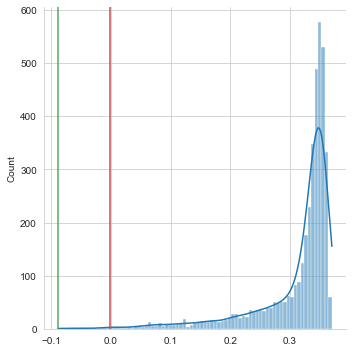

In [359]:
sns.displot(X_train_score_static, kind="hist" , kde = True)
plt.axvline(np.min(X_train_score_static[np.where(outliers_static_train==-1)]), c='g')
plt.axvline(np.max(X_train_score_static[np.where(outliers_static_train==-1)]), c='r')
# plt.title('Standard Isolation Forest (sklearn)', fontsize=15)
plt.show()

In [280]:
iso_outliers_train_static = np.where(outliers_static_train==-1)
iso_outliers_train_static

(array([  66,   67,   70,   71,  139,  140,  150,  279,  404,  549,  617,
         618,  700,  937, 1249, 1260, 2118, 2254, 2544, 2564, 3663]),)

In [281]:
np.intersect1d(abod_outliers_train_static, iso_outliers_train_static)

array([  67,   71,  140,  279,  617,  937, 1260])

### 2.2 Standard Isolation Forest & Extended Isolation Forest   (eif)

1) https://github.com/sahandha/eif/blob/master/Notebooks/EIF.ipynb

2) https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b

### Motion activities

In [282]:
import eif as iso

We train two sets of forests, F0 and F1. 

- __F0__ is the __Standard Isolation Forest__, which corresponds to extension level 0 in the context of EIF. 

- __F1__ is the __Extended Isolation Forest__ with extension 1

In [283]:
F0  = iso.iForest(X_train_motion.values,ntrees=500, sample_size=256, ExtensionLevel=0) # standard eif
F1  = iso.iForest(X_train_motion.values,ntrees=500, sample_size=256, ExtensionLevel=1)  # extended eif

compute_paths returns that anomaly score. It computes the depth each points reaches in each trained tree, and converts the ensemble aggregate to an anomaly score.

In [284]:
# Score the training data itself to see the distribution of the anomaly scores each point receives. 
S0 = F0.compute_paths(X_in=X_train_motion.values)
S1 = F1.compute_paths(X_in=X_train_motion.values)

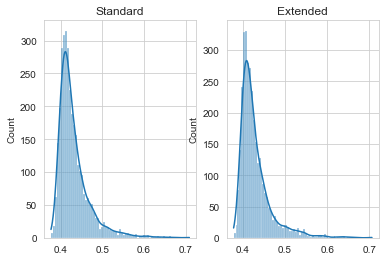

In [285]:
fig , axes = plt.subplots(1 , 2)

sns.histplot(S0,ax=axes[0] ,  kde = True )
axes[0].set_title("Standard")

sns.histplot(S1,ax=axes[1] ,  kde = True )
axes[1].set_title('Extended')

plt.show()

The distribution of anomaly scores are shown. By definition, anomalies are those that occur less frequently. So it makes sense that the number of points with higher anomaly scores reduces as the score increases.

In [286]:
ss0=np.sort(S0)
ss1=np.sort(S1)

outliers_ss0 = ss0[-736:] #top 736 outliers standard isolation forest
outliers_ss1 = ss1[-736:] #top 736 outliers extended isolation forest

### Static activities

In [287]:
F0  = iso.iForest(X_train_static.values,ntrees=500, sample_size=256, ExtensionLevel=0) # standard eif
F1  = iso.iForest(X_train_static.values,ntrees=500, sample_size=256, ExtensionLevel=1)  # extended eif

In [288]:
# Score the training data itself to see the distribution of the anomaly scores each point receives. 
S0 = F0.compute_paths(X_in=X_train_static.values)
S1 = F1.compute_paths(X_in=X_train_static.values)

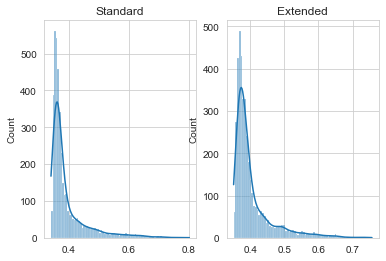

In [289]:
fig , axes = plt.subplots(1 , 2)

sns.histplot(S0,ax=axes[0] ,  kde = True )
axes[0].set_title("Standard")

sns.histplot(S1,ax=axes[1] ,  kde = True )
axes[1].set_title('Extended')

plt.show()

## 3. DENSITY-BASED APPROACH

### 3.1 Local Outlier Factor LOF

In [290]:
from sklearn.neighbors import LocalOutlierFactor

### Motion activities

In [360]:
clf = LocalOutlierFactor(contamination = 0.005)
outliers_LOF = clf.fit_predict(X_train_motion)

In [361]:
np.unique(outliers_LOF, return_counts=True)
# -1 stand for outliers, 1 stand for inliers

(array([-1,  1]), array([  17, 3268]))

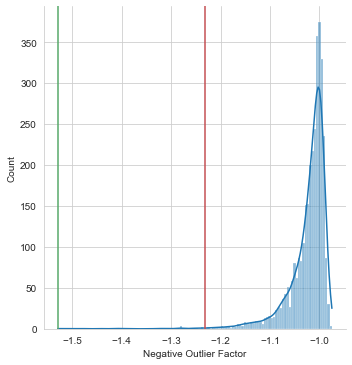

In [362]:
max_val = np.max(clf.negative_outlier_factor_[np.where(outliers_LOF==-1)])
min_val = np.min(clf.negative_outlier_factor_[np.where(outliers_LOF==-1)])

sns.displot(clf.negative_outlier_factor_, kind="hist" , kde = True)
plt.axvline(max_val, c='r')
plt.axvline(min_val, c='g')
#plt.title('Local Outlier Factor', fontsize=15)
plt.xlabel("Negative Outlier Factor")
plt.show()

In [363]:
LOF_outliers_train_motion = np.where(outliers_LOF==-1)
LOF_outliers_train_motion

(array([ 263,  521,  662,  698,  915, 1001, 1236, 1256, 1257, 1777, 1784,
        1797, 1816, 1817, 1986, 2145, 3195]),)

In [364]:
np.intersect1d(LOF_outliers_train_motion, iso_outliers_train_motion)

array([1236, 1816, 1817])

In [365]:
np.intersect1d(abod_outliers_train_motion, LOF_outliers_train_motion)

array([ 915, 1777, 1797, 1816])

### Static activities

In [366]:
clf = LocalOutlierFactor(contamination = 0.005)
outliers_LOF = clf.fit_predict(X_train_static)

In [367]:
np.unique(outliers_LOF, return_counts=True)
# -1 stand for outliers, 1 stand for inliers

(array([-1,  1]), array([  21, 4046]))

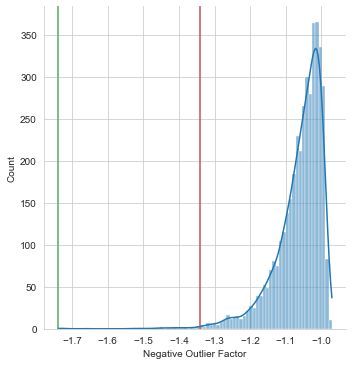

In [369]:
max_val = np.max(clf.negative_outlier_factor_[np.where(outliers_LOF==-1)])
min_val = np.min(clf.negative_outlier_factor_[np.where(outliers_LOF==-1)])

sns.displot(clf.negative_outlier_factor_, kind="hist" , kde = True)
plt.axvline(max_val, c='r')
plt.axvline(min_val, c='g')
#plt.title('Local Outlier Factor', fontsize=15)
plt.xlabel("Negative Outlier Factor")
plt.show()

In [300]:
LOF_outliers_train_static = np.where(outliers_LOF==-1)
LOF_outliers_train_static

(array([   0,   71,  140,  191,  192,  279,  602,  899,  928,  953, 1084,
        1097, 1260, 1525, 1677, 2025, 2527, 2614, 2615, 2629, 2787]),)

In [301]:
np.intersect1d(abod_outliers_train_static, LOF_outliers_train_static)

array([  71,  140,  279,  953, 1260, 1525, 2025])

In [302]:
np.intersect1d(LOF_outliers_train_static, iso_outliers_train_static)

array([  71,  140,  279, 1260])

## OULIERS COMPARISON

In [312]:
from functools import reduce

### MOTION ACTIVITIES

In [331]:
abod_outliers_train_motion

(array([ 625,  628,  637,  847,  915, 1161, 1224, 1777, 1797, 1812, 1816,
        1818, 1820, 1821, 2144, 2184, 2244]),)

In [324]:
LOF_outliers_train_motion

(array([ 263,  521,  662,  698,  915, 1001, 1236, 1256, 1257, 1777, 1784,
        1797, 1816, 1817, 1986, 2145, 3195]),)

In [325]:
iso_outliers_train_motion

(array([ 628, 1229, 1236, 1810, 1811, 1812, 1814, 1816, 1817, 1818, 1819,
        1820, 1821, 1836, 1837, 1839, 1840]),)

In [310]:
# outliers in common 
reduce(np.intersect1d, (abod_outliers_train_motion, LOF_outliers_train_motion, iso_outliers_train_motion))

array([1816])

In [370]:
np.intersect1d(abod_outliers_train_motion, iso_outliers_train_motion)

array([ 628, 1812, 1816, 1818, 1820, 1821])

In [371]:
np.intersect1d(abod_outliers_train_motion,LOF_outliers_train_motion )

array([ 915, 1777, 1797, 1816])

In [372]:
np.intersect1d(LOF_outliers_train_motion , iso_outliers_train_motion)

array([1236, 1816, 1817])

### STATIC ACTIVITIES

In [306]:
abod_outliers_train_static

(array([  67,   71,  140,  279,  292,  309,  432,  617,  924,  937,  953,
        1014, 1260, 1525, 1602, 1735, 1853, 2025, 2243, 2858, 2862]),)

In [307]:
LOF_outliers_train_static

(array([   0,   71,  140,  191,  192,  279,  602,  899,  928,  953, 1084,
        1097, 1260, 1525, 1677, 2025, 2527, 2614, 2615, 2629, 2787]),)

In [308]:
iso_outliers_train_static

(array([  66,   67,   70,   71,  139,  140,  150,  279,  404,  549,  617,
         618,  700,  937, 1249, 1260, 2118, 2254, 2544, 2564, 3663]),)

In [311]:
# outliers in common 
reduce(np.intersect1d, (abod_outliers_train_static, LOF_outliers_train_static, iso_outliers_train_static))

array([  71,  140,  279, 1260])

In [373]:
np.intersect1d(abod_outliers_train_static, iso_outliers_train_static)

array([  67,   71,  140,  279,  617,  937, 1260])

In [374]:
np.intersect1d(abod_outliers_train_static,LOF_outliers_train_static)

array([  71,  140,  279,  953, 1260, 1525, 2025])

In [375]:
np.intersect1d(LOF_outliers_train_static, iso_outliers_train_static)

array([  71,  140,  279, 1260])

## Building the csv New_train

__Adding a column named Outlier_label to the dataframe__

In [ ]:
X_train_motion["Outlier_label"] = list_outliers_motion_train

In [ ]:
X_train_static["Outlier_label"] = list_outliers_static_train

In [ ]:
New_X_train = pd.concat([X_train_static,X_train_motion])

In [ ]:
#New_X_train[New_X_train["Outlier_label"]==-1]

In [ ]:
df_train["Outlier_label"] = New_X_train["Outlier_label"]

In [ ]:
#df_train[df_train["Outlier_label"]==-1]

In [ ]:
df_train.to_csv('csv/New_train.csv', index=False )

In [ ]:
df_test.to_csv('csv/New_test.csv', index=False )